In [ ]:
# There is some dependency in the code on TF.
# D-Wave machines don't have it by default, so install
# if necessary.
!pip install tensorflow

In [16]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bns import generate, get_foms
from utils import get_dwave_sampler

from rbm.optimizers import RBMOptimizer
from rbm.rbm import RBM
from rbm.samplers import NaiveSampler, DWaveSampler

# Ignore the TF errors.

In [3]:
# For large RBMs finding an embedding might take a long time.
dw_sampler = get_dwave_sampler(100, 100)

Embedding found and fixed.


In [11]:
# Generate all 10-by-10 positive samples of bars and stripes.
positive_samples = generate(10)
# Shuffle for training.
np.random.shuffle(positive_samples)
# An SGD optimizer with momentum.
optimizer = RBMOptimizer()
# Naive Gibbs sampler with 50 Gibbs updates.
sampler = NaiveSampler(50)
# RBM with 100 hidden units. The number of visible units
# is inferred from data.
rbm = RBM(100, sampler, optimizer, "naive_rbm")

In [12]:
# Train on 256 out of 2046 positive samples. Could take ~2 hours.
rbm.fit(positive_samples[:256], epochs=4_000, batch_size=256)

Training time: 0:05:59.922882


In [4]:
# Save the trained model. Be careful not to overwrite any previously
# saved models you want to keep.
with open("trained_models/rbm.pickle", "wb") as file:
    pickle.dump(rbm, file)

# To load a trained model, use the following code:
# with open("trained_models/rbm.pickle", "rb") as file:
#     rbm = pickle.load(file)

In [5]:
results_file = Path("inference.csv")
if not results_file.exists():
    with open(results_file, "a") as file:
        file.write(f"RBM name,initialization,step,precision,recall,l2,MAD\n")

In [19]:
initialization = "classical"
visible = np.random.choice([0,1], size=(10_000, 100))

# You can start to notice most trends with 1000 updates
for i in range(1_001):
    # There are more changes during the first updates, so more
    # granularity is useful.
    if (i < 100) or (i % 10 == 0):
        precision, recall, l2, mad = get_foms(visible, positive_samples)
        with open(results_file, "a") as file:
            file.write(f"{rbm.name},{initialization},{i},{precision},{recall},{l2},{mad}\n")
    hidden, prob_hidden = rbm.sampler.infer(visible)
    visible, prob_visible = rbm.sampler.generate(hidden)

In [7]:
anneal_schedule=[[0.0, 0.0], [10.0, 0.4], [20.0, 0.4], [30, 1.0]]
params = {
    "anneal_schedule": anneal_schedule
}
sampler = DWaveSampler(
    dwave_sampler=dw_sampler,
    temp=32.0, # The higher the temperature, the closer the result to uniform distribution
    num_spin_reversal_transforms=10, # 10 seems to work better than none (one), otherwise haven't played around with this much
    num_gibbs_updates=0, # We need the raw output from D-Wave, rather than classically corrected one
    chain_strength=1, # Constant maximum
    dwave_params=params # This is where additional parameters from the D-Wave handbook can be included as a dictionary
)
sampler.rbm = rbm

In [10]:
initialization = "quantum"
# The parameter `visible` here only gives the correct dimensions for
# the sample to be obtained. In the default example that would be
# 10_000 reads with 100 visible units.
visible, _, _, _ = sampler.sample(visible)

for i in range(1_001):
    if (i < 100) or (i % 10 == 0):
        precision, recall, l2, mad = get_foms(visible, positive_samples)
        with open(results_file, "a") as file:
            file.write(f"{rbm.name},{initialization},{i},{precision},{recall},{l2},{mad}\n")
    hidden, prob_hidden = rbm.sampler.infer(visible)
    visible, prob_visible = rbm.sampler.generate(hidden)

In [19]:
df = pd.read_csv("inference.csv")
foms = ["precision", "recall", "l2", "MAD"]

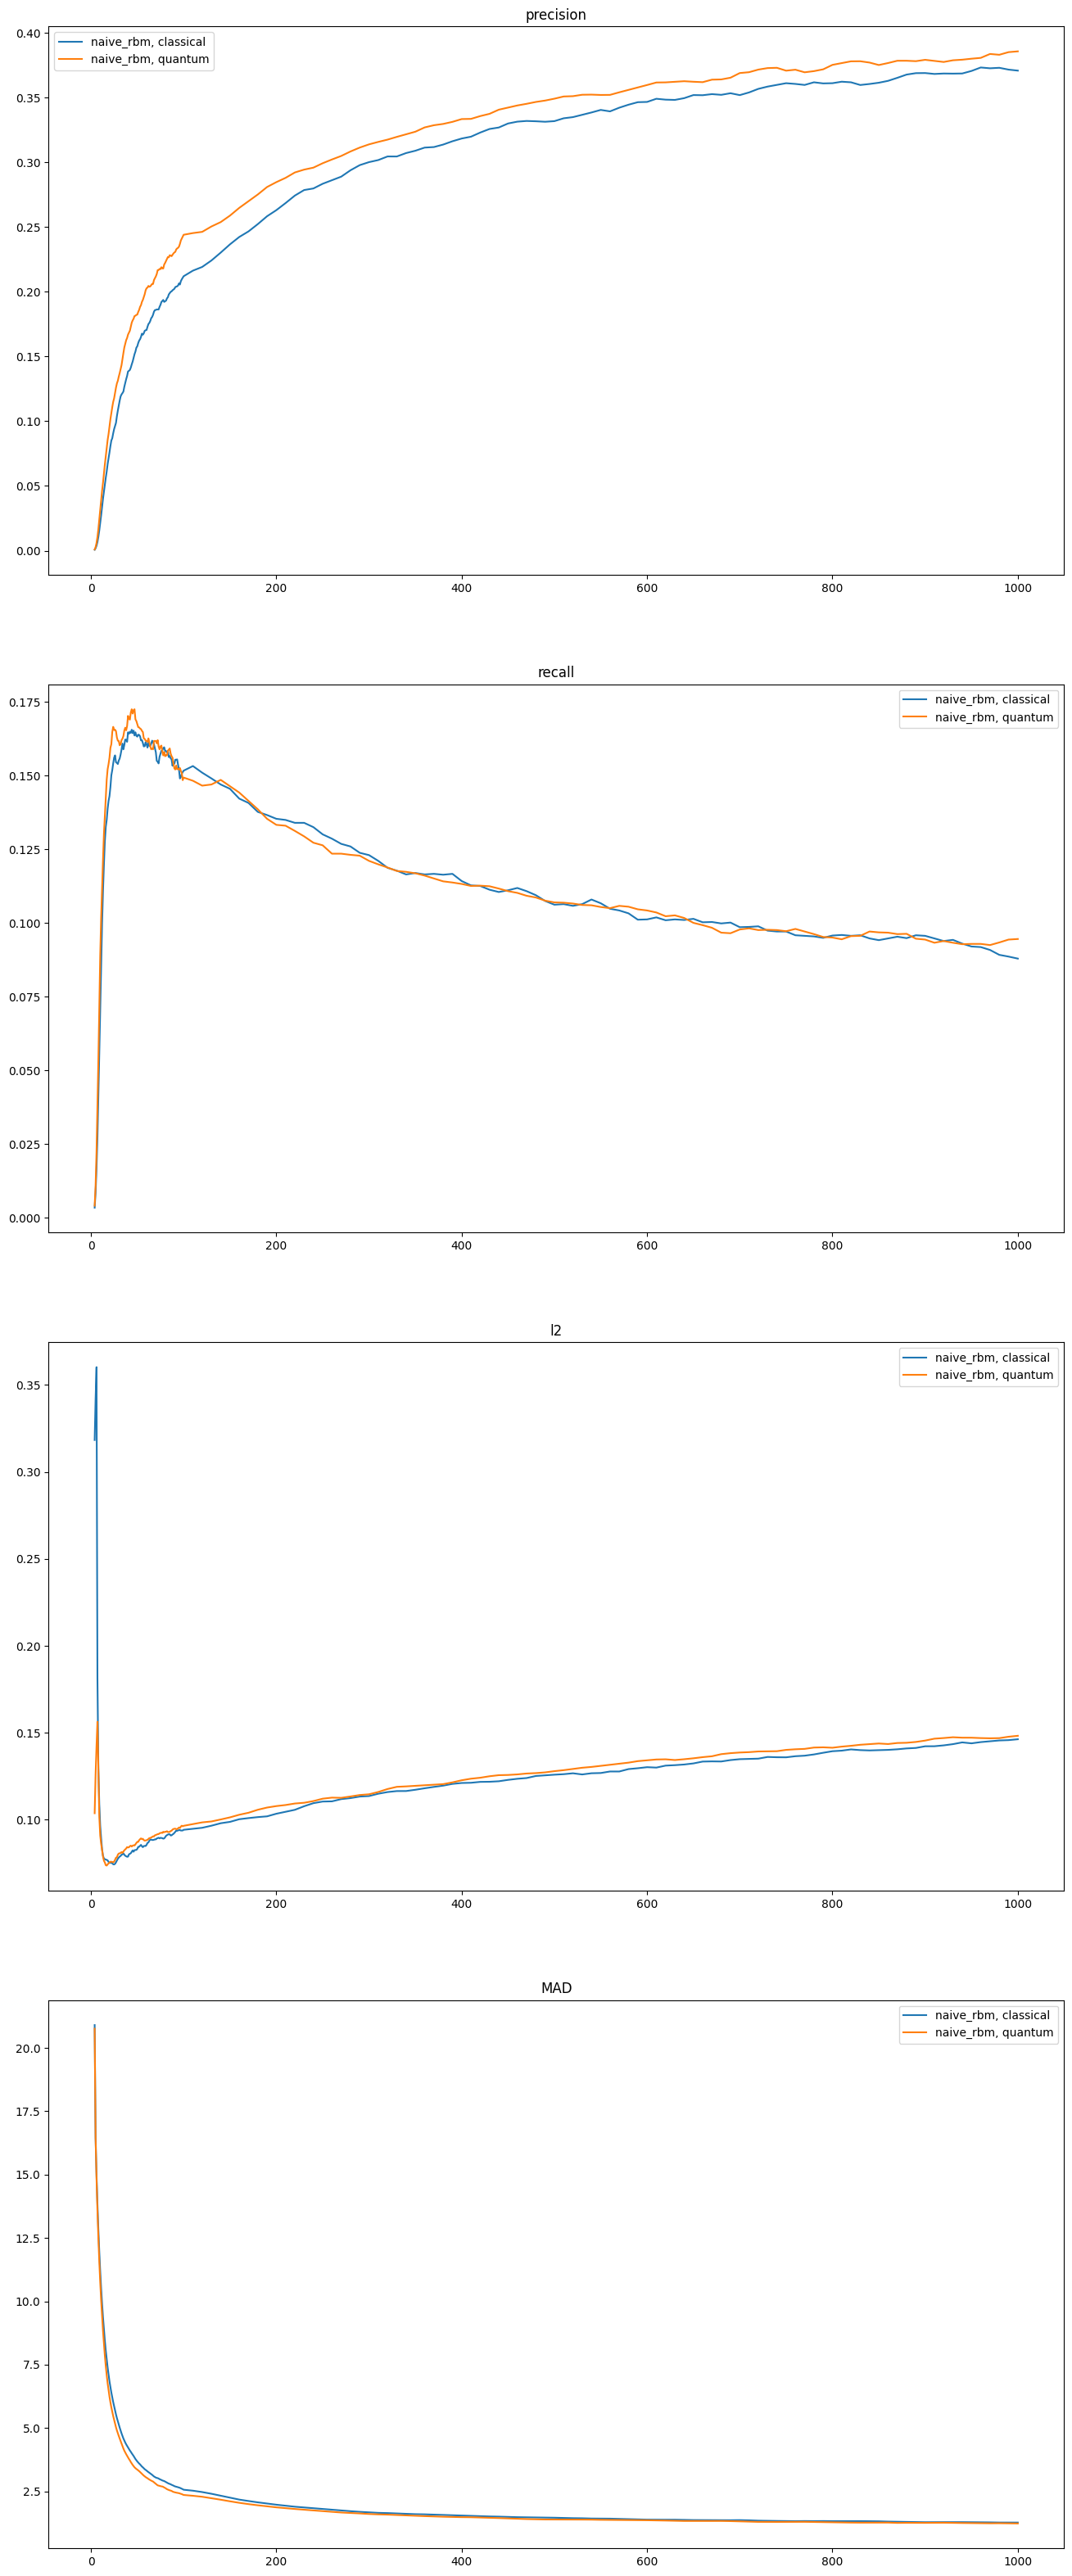

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(16, 40))
for fom, ax in zip(foms, axes):
    for (rbm_name, init), group in df.groupby(["RBM name", "initialization"]):
        # I'm plotting a rolling mean of 5 steps. You could just
        # plot group[fom] to get the raw plot.
        ax.plot(group["step"], group[fom].rolling(5).mean(), label=f"{rbm_name}, {init}")
    ax.set_title(fom)
    ax.legend()